# Healing ts approaches with missing value imputation

One of the problem of predictive clustering algorithm is missing points. Depends in our algorithm modification we can have more or less missing point, but after some time we can't predict any more because we have to much of them. For dealing with this problem we can apply healing algorithms. In this work we would like to try approaches discussed in article [Long-term missing value imputation for time series data using deep neural networks](https://link.springer.com/article/10.1007/s00521-022-08165-6). 


Having read the article carefully we have identified 3 approaches:
- [imputeTS](https://github.com/SteffenMoritz/imputeTS) R package, that provide several different imputation algorithm, from witch we choose 3 for now:
    1. missing Value Imputation by Interpolation,
    2. missing Value Imputation by Kalman Smoothing,
    3. missing Value Imputation by Weighted Moving Average;
- [mtsdi](https://cran.r-project.org/web/packages/mtsdi/index.html) R package, that provide EM algorithm based method for imputation of missing values in multivariate normal time series;
- Radial basis function network (RBF) with hyper parameters optimization (HPO).
Unfortunately there are no implementation provided for RBF with HPO, so we will try best hyperparameter from article and will compare them with `inputeTS` and `mtsdi`. 


For dealing with r packages we will use [rpy2](https://pypi.org/project/rpy2/) package and for RBF we will create our [torch](https://pytorch.org/docs/stable/torch.html) implementation.

## Try to run inputeTS

#### Import R packages

In [80]:
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import matplotlib.pyplot as plt

In [4]:
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x11218b190> [0]

In [5]:
utils.install_packages('imputeTS')
utils.install_packages('mtsdi')

R[write to console]: пробую URL 'https://cloud.r-project.org/src/contrib/imputeTS_3.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2183322 bytes (2.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/Users/alexglushko/miniconda3/envs/ts-horizon/lib/R/include" -DNDEBUG  -I'/Users/alexglushko/miniconda3/envs/ts-horizon/lib/R/library/Rcpp/include' -D_FORTIFY_SOURCE=2 -isystem /Users/alexglushko/miniconda3/envs/ts-horizon/include -mmacosx-version-min=10.9 -I/Users/alexglushko/miniconda3/envs/ts-horizon/include    -fPIC  -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /Users/alexglushko/miniconda3/envs/ts-horizon/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1698915189859/work=/usr/local/src/conda/r-base-4.3.2 -fdebug-prefix-map=/Users/alexglushko/miniconda3/envs/ts-horizon=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/Users/alexglushko/miniconda3/envs/ts-horizon/lib/R/include" -DNDEBUG  -I'/Users/alexglushko/miniconda

ld: warning: -pie being ignored. It is only used when linking a main executable
installing to /Users/alexglushko/miniconda3/envs/ts-horizon/lib/R/library/00LOCK-imputeTS/00new/imputeTS/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (imputeTS)
R[write to console]: 

R[write to console]: 
R[write to console]: Скачанные исходники пакетов находятся в
	‘/private/var/folders/p1/3m_zyv3s2wb5wryr6dgl_h7w0000gn/T/RtmphxqcWU/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Обновляю HTML-список пакетов в 

<rpy2.rinterface_lib.sexp.NULLType object at 0x11218b190> [0]

In [6]:
imputeTS = importr('imputeTS')
mtsdi = importr('mtsdi')

#### Make try healing of Lorenz series

In [82]:
dbscan_prediction = pd.read_csv('./data/dbscan_prediction.csv')
dbscan_prediction_true = pd.read_csv('./data/dbscan_prediction_true.csv')
pandas2ri.activate()

In [107]:
def plot_filled(x_fill, method_name):    
    fig, ax = plt.subplots(1,2,figsize=(18, 8))
    ax[0].plot(dbscan_prediction_true['x'].to_numpy()[:100], c='black', label='test')
    ax[0].scatter(np.arange(100), x_fill[-100:], c='lime', label='dbscan pred', s=13)
    ax[0].legend()
    ax[0].set_xlabel('observation number')
    ax[0].set_ylabel('value')
    ax[0].set_title(f"Healed ts by {method_name}")

    ax[1].plot(dbscan_prediction_true['x'].to_numpy()[:100], c='black', label='test')
    ax[1].scatter(np.arange(100), x.to_numpy()[-100:], c='lime', label='dbscan pred', s=13)
    ax[1].legend()
    ax[1].set_xlabel('observation number')
    ax[1].set_ylabel('value')
    ax[1].set_title("Not healed ts")

    plt.show()

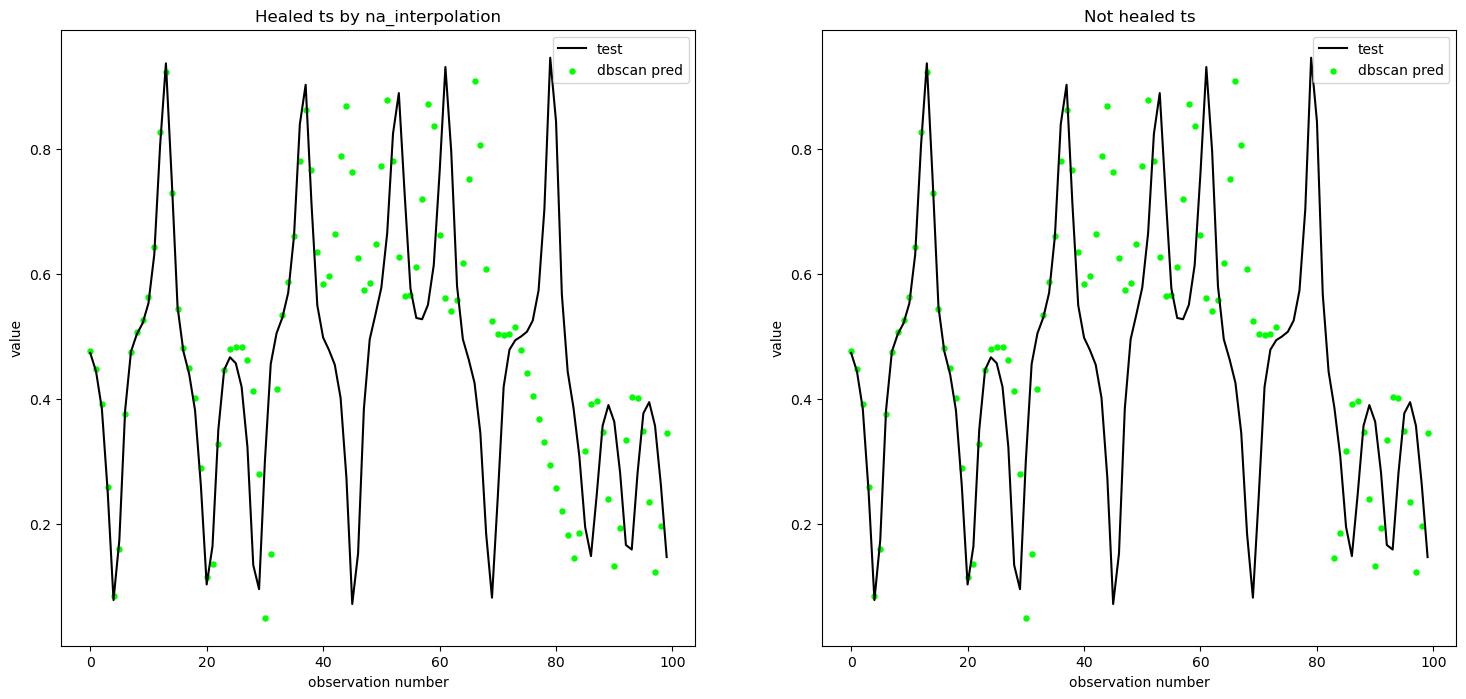

In [108]:
x = dbscan_prediction['x']
x_fill = imputeTS.na_interpolation(x)
plot_filled(x_fill, "na_interpolation")

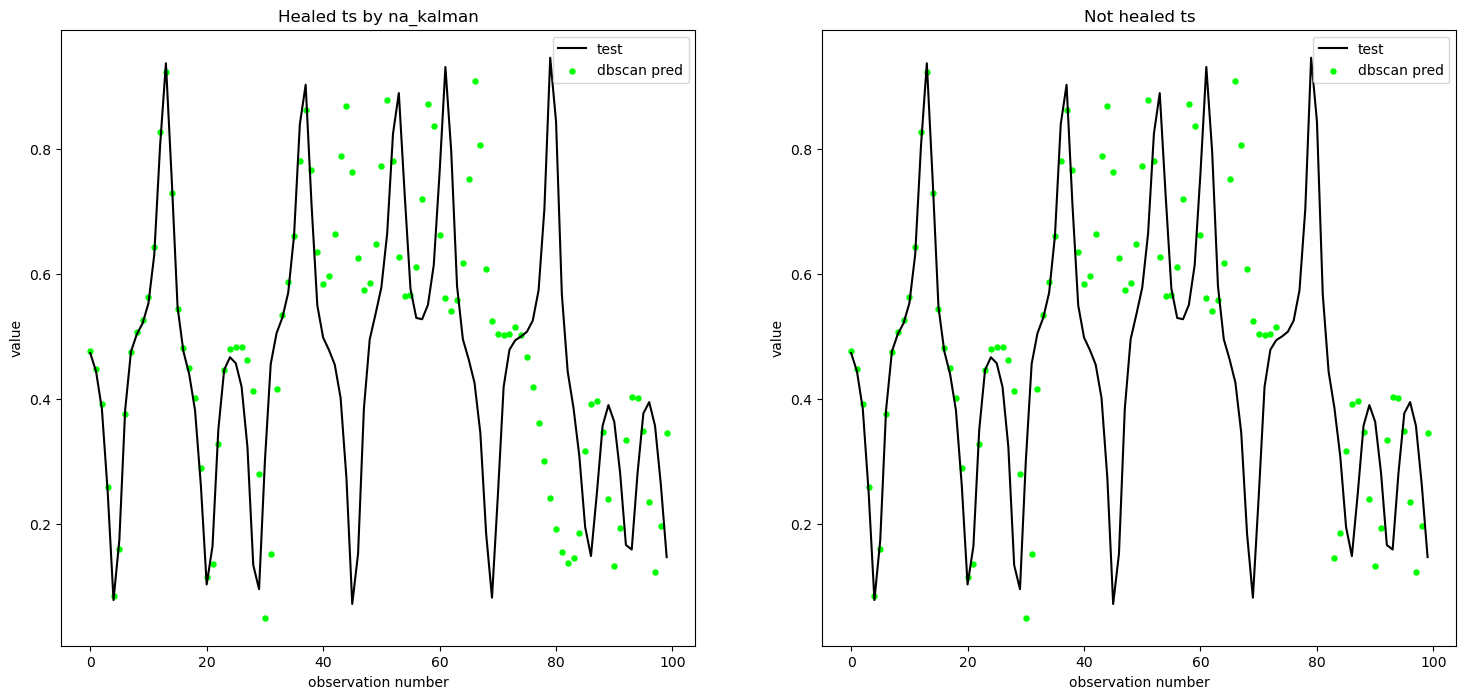

In [109]:
x_fill = imputeTS.na_kalman(x)
plot_filled(x_fill, "na_kalman")

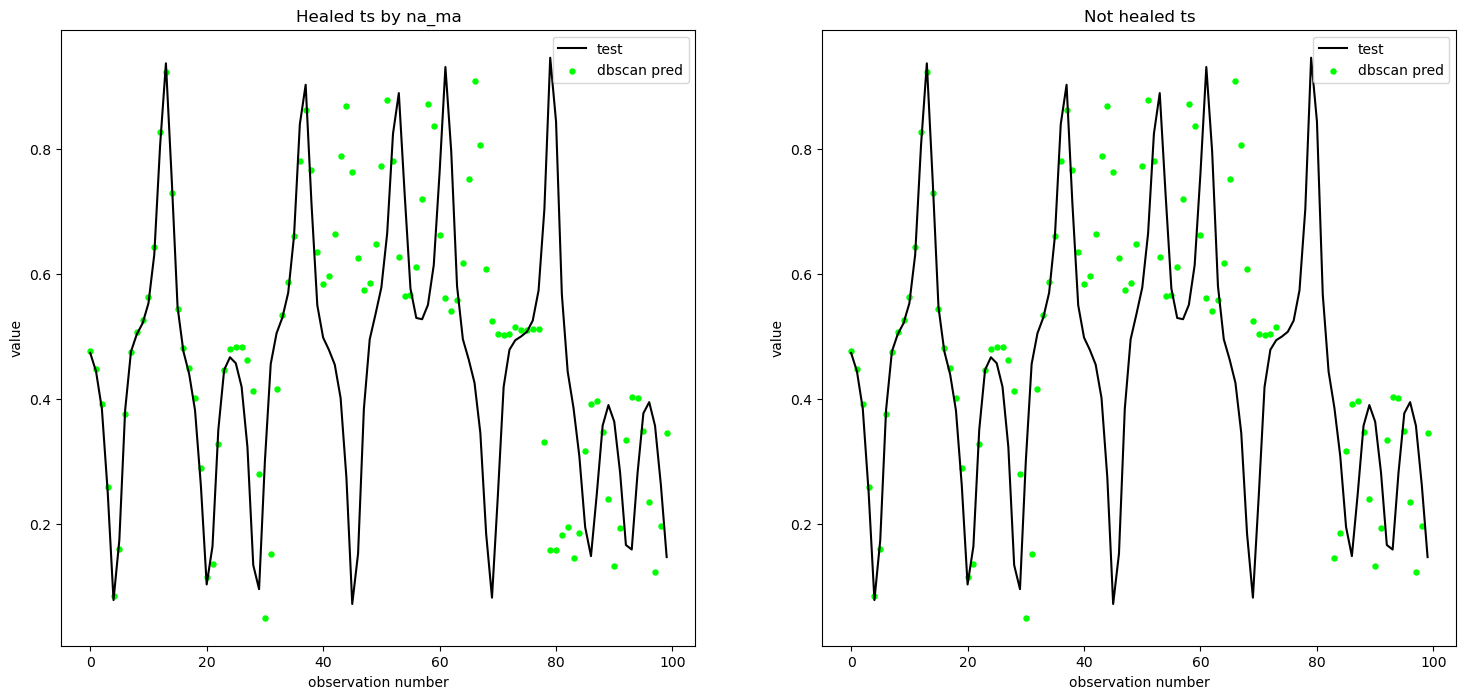

In [110]:
x_fill = imputeTS.na_ma(x)
plot_filled(x_fill, "na_ma")

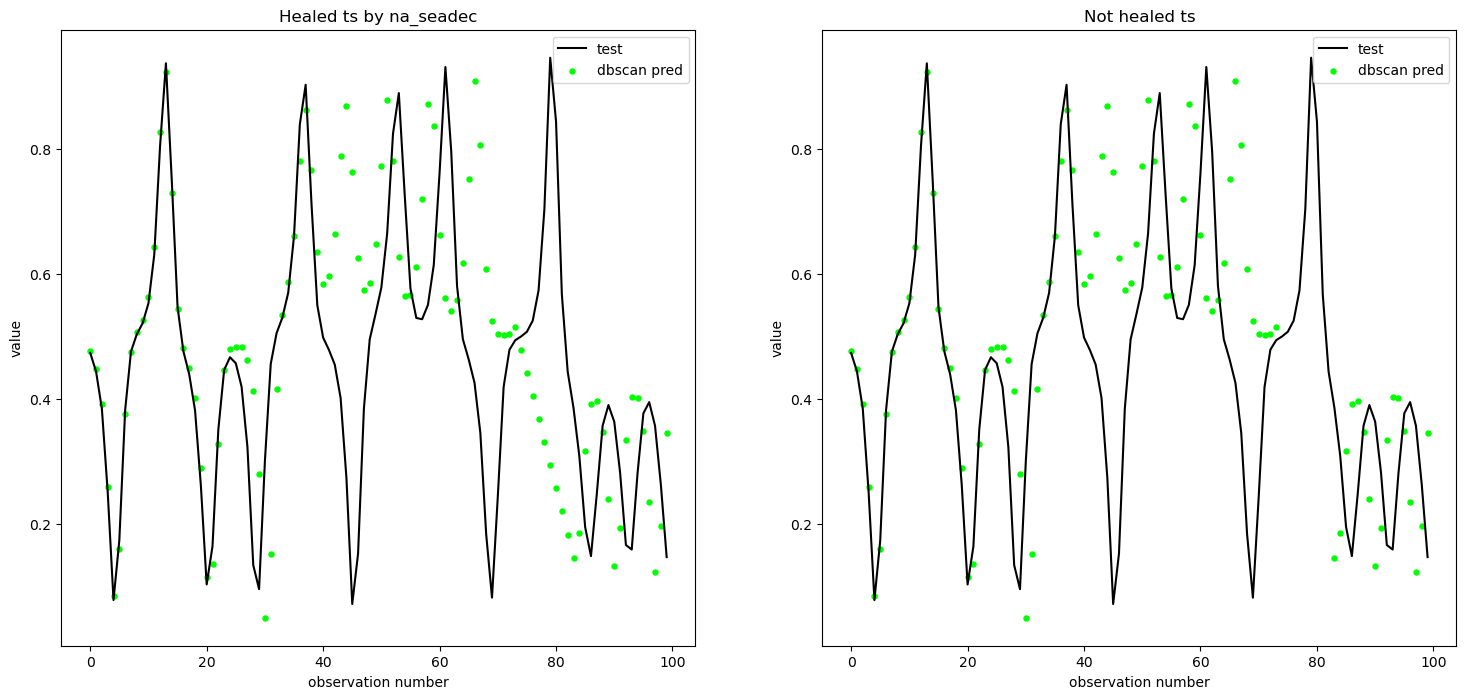

In [115]:
x_fill = imputeTS.na_seadec(x)
plot_filled(x_fill, "na_seadec")

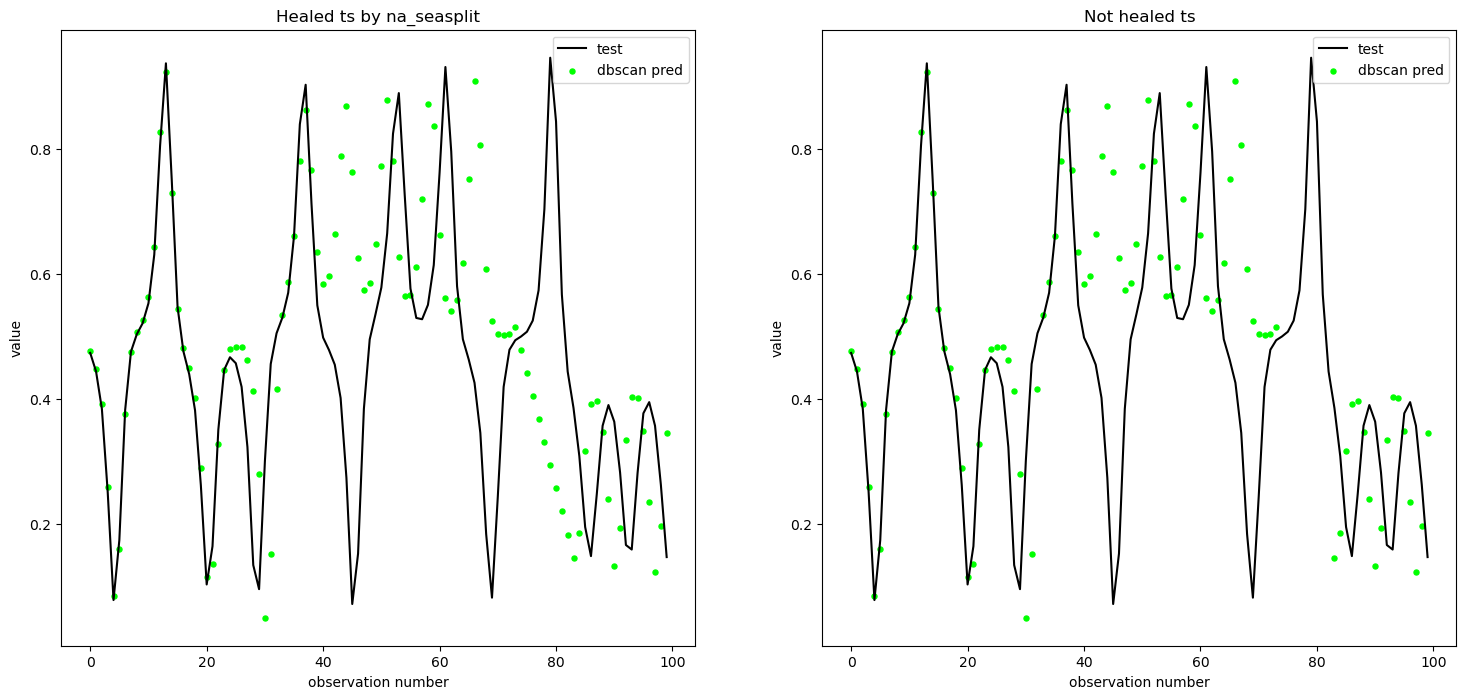

In [116]:
x_fill = imputeTS.na_seasplit(x)
plot_filled(x_fill, "na_seasplit")